<a href="https://colab.research.google.com/github/Datamin-D/Projects/blob/main/Parking_lot_demand_prediction/LH_%EC%A3%BC%EC%B0%A8%EC%9E%A5_%EC%88%98%EC%9A%94_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# import libraries

In [260]:
import pandas as pd
import numpy as np
import re
import time
import pickle
import tqdm
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


#설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#폰트
plt.rc('font', family='NanumBarunGothic') 

#안되면
#설치된 폰트 확인
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
font_list


#폰트
plt.rcParams['font.family'] = 'NanumBarunGothic' #히트맵은 잘됨

#여러번 쓸거면 코랩에서 드라이브에 넣기.
from matplotlib import font_manager, rc

# os.chdir('경로')
# font_name = font_manager.FontProperties(fname="NanumGothic.ttf").get_name()
# rc('font', family=font_name)

#

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


# import data

In [261]:
path = '/gdrive/MyDrive/대회, 프로젝트/LH dacon/data'
os.chdir(path)

In [262]:
age_gend = pd.read_csv('age_gender_info.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

# EDA & preprocsseing

In [263]:
train.info() #등록차량수가 y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

Text(0, 0.5, 'counts')

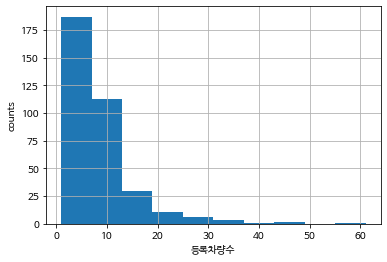

In [264]:
# 등록 차량수 분포 확인
train['등록차량수'].value_counts().sort_index().hist()
plt.xlabel('등록차량수')
plt.ylabel('counts')

In [265]:
train['단지코드'].value_counts() #423개 unique

C1439    48
C2132    47
C1859    40
C1790    33
C2597    32
         ..
C2431     2
C2437     1
C2188     1
C2340     1
C2520     1
Name: 단지코드, Length: 423, dtype: int64

Text(0, 0.5, 'counts')

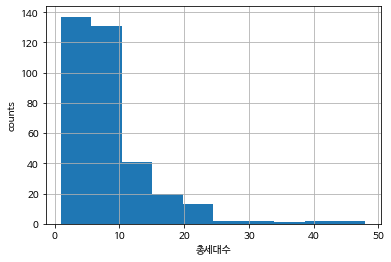

In [266]:
train['총세대수'].value_counts().sort_index().hist()
plt.xlabel('총세대수')
plt.ylabel('counts')

In [267]:
train['임대건물구분'].value_counts() #아파트 or 상가
# 
def apart_or_arcade(x):
  if x == '아파트':
    return 1
  else:
    return 0
train['apart'] = train['임대건물구분'].apply(lambda x: apart_or_arcade(x))  #2390 562
train.drop('임대건물구분',axis = 1, inplace = True)
train['apart'].value_counts() # 변환 완료

1    2390
0     562
Name: apart, dtype: int64

In [268]:
#test
test['apart'] = test['임대건물구분'].apply(lambda x: apart_or_arcade(x))  #2390 562
test.drop('임대건물구분',axis = 1, inplace = True)
test['apart'].value_counts() # 변환 완료

1    845
0    177
Name: apart, dtype: int64

In [269]:
# 지역
train['region'] = train['지역']
train.drop('지역',axis = 1, inplace = True)
train['region'].value_counts() # 원핫 인코딩ㄱ 수도권, 지방 등 여러개로 나눌 수도 있을듯.

경기도        621
경상남도       369
부산광역시      328
대전광역시      266
강원도        187
충청북도       163
충청남도       158
전라남도       151
광주광역시      141
경상북도       119
전라북도       109
대구광역시      102
제주특별자치도     91
서울특별시       64
세종특별자치시     47
울산광역시       36
Name: region, dtype: int64

In [270]:
#test
# 지역
test['region'] = test['지역']
test.drop('지역',axis = 1, inplace = True)
test['region'].value_counts() # 원핫 인코딩ㄱ 수도권, 지방 등 여러개로 나눌 수도 있을듯.

경기도        259
강원도        106
부산광역시       88
경상남도        85
울산광역시       73
경상북도        58
대전광역시       56
충청북도        51
광주광역시       46
전라북도        41
충청남도        41
전라남도        37
대구광역시       36
제주특별자치도     26
세종특별자치시     19
Name: region, dtype: int64

In [271]:
#공급유형
train['lease_type'] = train['공급유형']
train.drop('공급유형',axis = 1, inplace = True)
train['lease_type'].value_counts() #원핫인코딩..? 흠.. 공공임대같은 경우 합칠 수도 있을듯.


국민임대         1758
임대상가          562
행복주택          213
공공임대(10년)     205
영구임대          152
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
공공분양            7
공공임대(5년)        3
Name: lease_type, dtype: int64

In [272]:
#공급유형
test['lease_type'] = test['공급유형']
test.drop('공급유형',axis = 1, inplace = True)
test['lease_type'].value_counts() #원핫인코딩..? 흠.. 공공임대같은 경우 합칠 수도 있을듯.



국민임대         622
임대상가         177
행복주택         124
영구임대          45
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: lease_type, dtype: int64

In [273]:
train['전용면적'].value_counts().sort_index() # 전용면적: 실제로 독점적으로 쓸 수 있는 면적. 전용면적 + 공용면적 = 공급면적 

12.62     1
14.10     6
14.17     1
15.00     8
16.00     1
         ..
317.17    1
401.50    1
404.65    2
407.97    1
583.40    5
Name: 전용면적, Length: 679, dtype: int64

In [274]:
train['전용면적별세대수'].value_counts() # 1인가구가 압도적으로 많음. 

1      562
30      49
60      48
24      47
120     42
      ... 
532      1
524      1
516      1
512      1
496      1
Name: 전용면적별세대수, Length: 403, dtype: int64

Text(0, 0.5, 'counts')

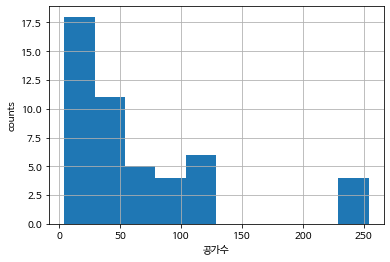

In [275]:
train['공가수'].value_counts().sort_index().hist() # 공가수 = 빈 세대
plt.xlabel('공가수')
plt.ylabel('counts')

In [276]:
train['자격유형'].value_counts() # 무슨 컬럼? 

A    1801
D     569
H     155
J     114
C      95
I      49
E      37
K      33
L      33
N      30
B      21
G       9
F       3
M       2
O       1
Name: 자격유형, dtype: int64

In [277]:
train['임대보증금'].value_counts().sort_index() # 결측치 발견 '-'

# train['임대보증금'].value_counts().sort_index()

-            12
10000000      2
100400000     1
10043000      1
10060000      2
             ..
99261000      2
9930000       1
9972000       4
9984000       3
9985000       2
Name: 임대보증금, Length: 957, dtype: int64

In [278]:
# 결측치 명시
train = train.replace('-',np.nan)
test = test.replace('-',np.nan)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   전용면적                          2952 non-null   float64
 3   전용면적별세대수                      2952 non-null   int64  
 4   공가수                           2952 non-null   float64
 5   자격유형                          2952 non-null   object 
 6   임대보증금                         2371 non-null   object 
 7   임대료                           2362 non-null   object 
 8   도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 9   도보 10분거리 내 버스정류장 수            2948 non-null   float64
 10  단지내주차면수                       2952 non-null   float64
 11  등록차량수                         2952 non-null   float64
 12  apart                         2952 non-null   int64  
 13  reg

Text(0, 0.5, 'counts')

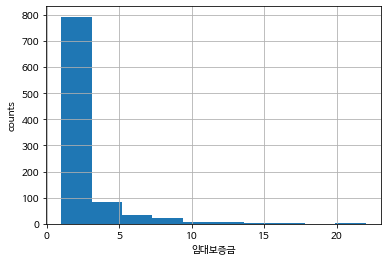

In [279]:
train['임대보증금'].value_counts().sort_index().hist() # 공가수 = 빈 세대
plt.xlabel('임대보증금')
plt.ylabel('counts')


Text(0, 0.5, 'counts')

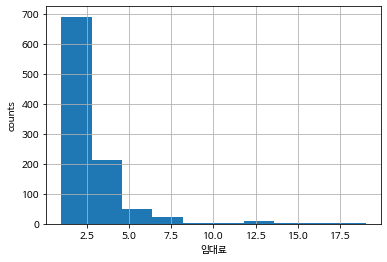

In [280]:
train['임대료'].value_counts().sort_index().hist() # 공가수 = 빈 세대
plt.xlabel('임대료')
plt.ylabel('counts')


0.0    2302
1.0     400
2.0      33
3.0       6
Name: subway, dtype: int64

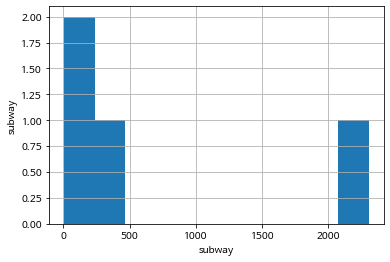

In [281]:
train['subway'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)']
train.drop('도보 10분거리 내 지하철역 수(환승노선 수 반영)',axis = 1,inplace = True)

test['subway'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)']
test.drop('도보 10분거리 내 지하철역 수(환승노선 수 반영)',axis = 1,inplace = True)


train['subway'].value_counts().sort_index().hist() # 공가수 = 빈 세대
plt.xlabel('subway')
plt.ylabel('subway')
train['subway'].value_counts() # 있냐 없냐고 바꿀 수도 있을 듯. 환승노선 고려라서. 

## BASELINE 용 컬럼 단순정리

In [282]:
train_drop = train.drop(['단지코드','자격유형','region','lease_type'],axis = 1)
train_drop.info()

test_drop = test.drop(['단지코드','자격유형','region','lease_type'],axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   총세대수                2952 non-null   int64  
 1   전용면적                2952 non-null   float64
 2   전용면적별세대수            2952 non-null   int64  
 3   공가수                 2952 non-null   float64
 4   임대보증금               2371 non-null   object 
 5   임대료                 2362 non-null   object 
 6   도보 10분거리 내 버스정류장 수  2948 non-null   float64
 7   단지내주차면수             2952 non-null   float64
 8   등록차량수               2952 non-null   float64
 9   apart               2952 non-null   int64  
 10  subway              2741 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 253.8+ KB


In [283]:
test_drop = test.drop(['단지코드','자격유형','region','lease_type'],axis = 1)

In [284]:
# type to float
train_drop = train_drop.astype('float')
train_drop.info()

test_drop = test_drop.astype('float')
test_drop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   총세대수                2952 non-null   float64
 1   전용면적                2952 non-null   float64
 2   전용면적별세대수            2952 non-null   float64
 3   공가수                 2952 non-null   float64
 4   임대보증금               2371 non-null   float64
 5   임대료                 2362 non-null   float64
 6   도보 10분거리 내 버스정류장 수  2948 non-null   float64
 7   단지내주차면수             2952 non-null   float64
 8   등록차량수               2952 non-null   float64
 9   apart               2952 non-null   float64
 10  subway              2741 non-null   float64
dtypes: float64(11)
memory usage: 253.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   총세대

In [285]:
# dropna
train_drop.dropna(inplace = True)

## 컬럼 별 상관관계 확인 using heat map


In [286]:
# scaling

In [287]:
plt.figure(figsize=(20,15))
sns.heatmap(df_scaled.corr(), annot=True, fmt='.2f', square=True)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.title('Heatmap of df', fontsize=3)

plt.show()

NameError: ignored

<Figure size 1440x1080 with 0 Axes>

#Evaluation Metrics

In [288]:
from sklearn.metrics import make_scorer
ev_df_material = dict()
# r2 sklearn꺼로 수정해서 다시 구현, mape sklearn꺼는 안됨. 없음. --> 수정, r2 squared 추가

def metrics(model,x_train,y_train,train_pred):
  r2_train = np.round(r2_score(y_train, train_pred),2)

  def adjusted_r_squared(X, Y, r2):

      n = len(Y)
      p = X.shape[1]
      adj_r = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

      return adj_r
  print("train set score(adj R square):",np.round(adjusted_r_squared(x_train, y_train,r2_train),2))
  

  ev_df_material[model_name + '_adjr2_train'] = np.round(adjusted_r_squared(x_train, y_train,r2_train),2)
  
  #y_train= np.array(y_train)

  # MAE Mean absolute error --> MSE보다 특이치에 robust 절댓값이라서
  print("train set score(MAE):",np.round(mean_absolute_error(y_train, train_pred),2)) #.sklearnmetrics(y_true, y_pred)

  
  ev_df_material[model_name + '_mae_train'] = np.round(mean_absolute_error(y_train, train_pred),2)


  


# Model 훈련

In [289]:
y_train = train_drop['등록차량수']
train_drop.drop('등록차량수',axis = 1, inplace = True)
x_train = train_drop


x_test = test_drop
x_train

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 버스정류장 수,단지내주차면수,apart,subway
0,900.0,39.72,134.0,38.0,15667000.0,103680.0,3.0,1425.0,1.0,0.0
1,900.0,39.72,15.0,38.0,15667000.0,103680.0,3.0,1425.0,1.0,0.0
2,900.0,51.93,385.0,38.0,27304000.0,184330.0,3.0,1425.0,1.0,0.0
3,900.0,51.93,15.0,38.0,27304000.0,184330.0,3.0,1425.0,1.0,0.0
4,900.0,51.93,41.0,38.0,27304000.0,184330.0,3.0,1425.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2947,239.0,49.20,19.0,7.0,11346000.0,116090.0,1.0,166.0,1.0,0.0
2948,239.0,51.08,34.0,7.0,14005000.0,142310.0,1.0,166.0,1.0,0.0
2949,239.0,51.73,34.0,7.0,14005000.0,142310.0,1.0,166.0,1.0,0.0
2950,239.0,51.96,114.0,7.0,14005000.0,142310.0,1.0,166.0,1.0,0.0


## Random Forest

In [202]:
start = time.time()  # 시작 시간 저장

from sklearn.ensemble import RandomForestRegressor
# 하이퍼파라미터 튜닝 using grid search
from sklearn.model_selection import GridSearchCV
#RF gave max_features = n_features/3 for regression
regressor = RandomForestRegressor()
rf_param_grid =  {
    'n_estimators' : [50,100,200,400,800],
    'max_depth' :[2,4,6,8,10],
    'min_samples_leaf' : [3,5,7,9],
    'min_samples_split' : [2,3,5,9,11,13]
}

# min_samples_leaf: 리프노드가 되기 위한 최소한의 샘플 수
# min_samples_split: 노드를 분할하기 위한 최소한의 데이터 수

grid_search = GridSearchCV(estimator = regressor, param_grid = rf_param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2) #,score = 'mean_squared_error'? 뭘로쟴..?
grid_search.fit(x_train,y_train)
grid_search.best_params_
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 보삼

# 이 데이터에는.. estimator 좀 적어도 될듯

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 11.7min finished


{'max_depth': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 50}

In [290]:
# model trainig

regressor = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'], max_depth = grid_search.best_params_['max_depth'],
                                  min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                  min_samples_split = grid_search.best_params_['min_samples_split'], n_jobs=-1,random_state = 0)
regressor.fit(x_train,y_train)

# predict

y_train = np.array(y_train)
#test_pred = regressor.predict()
train_pred = regressor.predict(x_train)
# test_pred = regressor.predict(x_test)


#eval metrics
model_name = 'rf'

metrics(regressor,x_train,y_train,train_pred)

train set score(adj R square): 0.86
train set score(MAE): 111.38


## XG_Boost

In [339]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.05 ,0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [ 200, 500, 800,1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                      
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 4,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(x_train,y_train)

    return gsearch.best_params_
tuned = hyperParameterTuning(x_train, y_train)

Fitting 4 folds for each of 576 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed: 14.6min finished


In [ ]:
#튜닝 후 다시

#xgb_model = XGBRegressor(tuned)
xgb_model = XGBRegressor(
    objective = tuned['objective'],
    colsample_bytree= tuned['colsample_bytree'],
    learning_rate= tuned['learning_rate'],
    max_depth= tuned['max_depth'],
    min_child_weight= tuned['min_child_weight'],
    n_estimators= tuned['n_estimators'],
    subsample= tuned['subsample'])

# %time xgb_model.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_test, y_test)], verbose=True) 원 코드
%time xgb_model.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_train, y_train)] , verbose=True)

In [342]:
#test_pred = regressor.predict()
train_pred = xgb_model.predict(x_train)

#eval metrics
model_name = 'xg'
metrics(xgb_model,x_train,y_train,train_pred)


train set score(adj R square): 0.91
train set score(MAE): 91.25


# Test data Predict

In [343]:
# x_test 용 na 채우기 - 각 컬럼의 평균값을 활용.
lease_deposit_mean = x_train['임대보증금'].mean()
lease_cost_mean = x_train['임대료'].mean()
x_train['subway'].mean()
subway = 0

x_test['임대보증금'] = x_test['임대보증금'].fillna(lease_deposit_mean)
x_test['임대료'] = x_test['임대료'].fillna(lease_cost_mean)
x_test['subway'] = x_test['subway'].fillna(subway)
x_test.info()
# Test data 용 

test_pred = regressor.predict(x_test)


# 간이로.. pred 예측
pred_df = pd.DataFrame(test_pred)
code = test['단지코드']

test_code = pd.concat([pred_df,code], axis =1)
test_code_group = test_code.groupby('단지코드').mean()

test_code_group = test_code_group.reset_index()
test_code_group['code'] = test_code_group['단지코드']
test_code_group.drop('단지코드',axis = 1,inplace = True)

test_code_group = test_code_group[['code',0]]
test_code_group


# test_code_group
# pd.merge(sample, test_code_group, on = 'code', how = 'left')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   총세대수                1022 non-null   float64
 1   전용면적                1022 non-null   float64
 2   전용면적별세대수            1022 non-null   float64
 3   공가수                 1022 non-null   float64
 4   임대보증금               1022 non-null   float64
 5   임대료                 1022 non-null   float64
 6   도보 10분거리 내 버스정류장 수  1022 non-null   float64
 7   단지내주차면수             1022 non-null   float64
 8   apart               1022 non-null   float64
 9   subway              1022 non-null   float64
dtypes: float64(10)
memory usage: 80.0 KB


,code,0
0,C1003,337.831584
1,C1006,350.685044
2,C1016,698.775894
3,C1019,288.640731
4,C1030,84.800128
...,...,...
145,C2653,735.563324
146,C2675,959.862292
147,C2676,347.915368
148,C2688,91.024627


# Submission

In [344]:
submission = pd.merge(sample, test_code_group, on = 'code', how = 'left')

submission.drop('num',axis = 1, inplace = True)
submission['num'] = submission[0]
submission.drop(0,axis = 1,inplace = True)

file_name = 'submission_base_xgb.csv'
submission.to_csv(file_name,index = False)
pd.read_csv(file_name)

,code,num
0,C1072,700.674773
1,C1128,1059.503855
2,C1456,560.615475
3,C1840,566.684450
4,C1332,966.681455
...,...,...
145,C2456,288.640731
146,C1266,531.070684
147,C2152,84.800128
148,C1267,472.880927
